#**Recherche et Récupération de Données Scientifiques**

##**Introduction**

Dans ce notebook, nous allons démontrer le processus de recherche et récupération d'informations scientifiques à partir d'un corpus d'articles en utilisant des techniques de Natural Language Processing (NLP), des modèles d'embeddings, et Chroma, une base de données vectorielle. Ce pipeline permet d'extraire des paragraphes pertinents d'articles et de visualiser la similarité sémantique entre une requête utilisateur et les textes récupérés.

________________________________

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Sujet1NLP3D

/content/drive/MyDrive/Sujet1NLP3D


###**Installation de Chroma**

Chroma est une base de données vectorielle permettant de stocker et de rechercher des embeddings. Nous l’installons ici pour manipuler et interroger des embeddings issus des textes.

In [3]:
!pip install chromadb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 607.0/607.0 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 65.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.8/273.8 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 88.5 MB/s eta 0:00:0

###**Initialisation de Chroma et Chargement du Modèle DistilBERT**

Nous chargeons les bibliothèques nécessaires, notamment DistilBERT, un modèle NLP performant pour générer des embeddings de texte, et Chroma pour la gestion des embeddings stockés.

In [4]:
import chromadb
import pandas as pd
import re
from transformers import DistilBertTokenizer, DistilBertModel

###**Initialisation de Chroma avec un Répertoire Persistant**

Cette étape initialise le client Chroma et configure le répertoire de stockage des embeddings persistants. La collection "Article_Embedding" sera utilisée pour ajouter et interroger des embeddings de texte.

In [5]:
# Indiquer le chemin vers le répertoire de Chroma dans Google Drive
CHROMA_PATH = "chroma_db_persistent"

# Initialiser le client Chroma avec le répertoire persistant
client = chromadb.PersistentClient(path=CHROMA_PATH) # Set the persist directory here

# Create or get the collection, persist_directory is no longer needed.
collection = client.get_or_create_collection("Article_Embedding")

###**Chargement du Modèle DistilBERT**

Nous téléchargeons le tokenizer et le modèle DistilBERT pré-entraîné à partir de Hugging Face. DistilBERT est un modèle léger qui permet d'obtenir des embeddings de phrases ou de paragraphes.

In [6]:
# Charger les modèles
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

###**Fonction de Génération d'Embeddings**

Cette fonction convertit un texte donné en embedding. Elle prend en entrée un texte, le tokenize, et génère un vecteur numérique représentant la sémantique du texte. L'output est l'embedding de la phrase ou du paragraphe.

In [7]:
def get_distilbert_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True, padding=True)
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy().reshape(-1)  # Reshape to 1D

###**Extraction d'Informations avec Chroma**

Cette fonction interroge Chroma avec un **embedding** de requête. Elle renvoie les sections les plus similaires dans la base de données et affiche leurs métadonnées, comme le titre et la position dans le document. Le résultat est structuré dans un **DataFrame**.

In [8]:
# Fonction pour interroger Chroma et structurer les résultats dans un DataFrame
def extract_information_from_chroma(query, num_results=5):
    # Générer l'embedding pour la requête
    query_embedding = get_distilbert_embeddings(query)

    # Rechercher les documents les plus similaires dans Chroma
    results = collection.query(
        query_embeddings=[query_embedding.tolist()],
        n_results=num_results
    )

    # Extraire les documents (sections) et métadonnées
    documents = results['documents']
    metadatas = results['metadatas']

    # Créer une liste pour stocker les résultats sous forme de dictionnaires
    extracted_data = []

    # Parcourir les documents et métadonnées pour lier chaque section à ses métadonnées
    for doc_idx, doc_sections in enumerate(documents):
        for section_idx, section in enumerate(doc_sections):
            metadata = metadatas[doc_idx][section_idx]

            # Ajouter la section, ses métadonnées et le texte à la liste
            extracted_data.append({
                'Section': section,  # Le texte de la section
                'Metadata': metadata  # Métadonnées correspondantes
            })

    # Créer un DataFrame avec les résultats extraits
    df_results = pd.DataFrame(extracted_data)
    return df_results

###**Exemple de Requête**

Nous utilisons une requête spécifique sur des techniques avancées d'optimisation des moteurs systoliques dans les FPGA. Cette requête est transformée en embedding et interrogée dans Chroma pour récupérer les paragraphes les plus pertinents.

In [9]:
# Exemple d'utilisation
query = """
Advanced techniques for optimizing systolic engines in FPGAs,
including the use of DSP48E2 blocks in neural network architectures.
These techniques encompass weight prefetching in matrix systolic
engines to improve computational efficiency in embedded systems.
In particular, the focus is on improving performance in neural
network FPGA accelerators, such as Google's TPUv1 and Xilinx Vitis AI DPU,
which exploit specific architectures to maximize parallelization and energy efficiency.
Recent advances in multiplexing techniques in DSP48E2, ring accumulator design, and power
consumption reduction are also considered to provide state-of-the-art solutions for complex neural systems.
This approach also explores the integration of systolic engines in FPGA systems for neuromorphic applications,
such as neural network-based accelerators. spiking neurons, with key technical optimizations aimed at
reducing resource usage and improving overall computational performance.
"""
df = extract_information_from_chroma(query)
df

,Section,Metadata
0,while significant progress has been made in vi...,"{'file_name': 'article_101_segmented.txt', 'pa..."
1,our findings in this paper confirm that there ...,"{'file_name': 'article_10_segmented.txt', 'par..."
2,cortexcompile- harnessing cortical-inspired ar...,"{'file_name': 'article_30_segmented.txt', 'par..."
3,and efficiency in handling matrix multiplicati...,"{'file_name': 'article_10_segmented.txt', 'par..."
4,"in table 2, we summarize the state-of-the-art ...","{'file_name': 'article_69_segmented.txt', 'par..."


###**Réduction de Dimension et Visualisation des Embeddings**

Nous utilisons la réduction de dimensions, ici avec PCA ou t-SNE, pour visualiser les embeddings dans un espace 2D. Cela permet de mieux comprendre les relations entre la requête et les paragraphes extraits.

**calculate_similarity** et la fonction qui calcule la similarité cosinus entre l'embedding de la requête et les embeddings des paragraphes extraits, fournissant une mesure quantitative de la proximité sémantique.

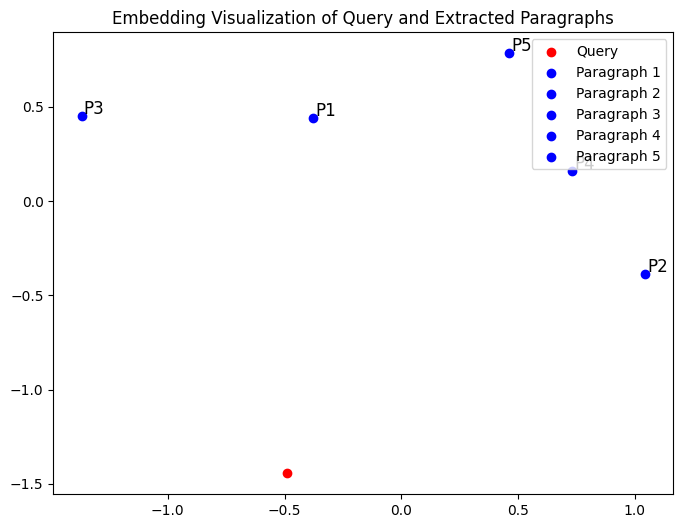

Similarity between query and paragraph 1: 0.9596
Similarity between query and paragraph 2: 0.9572
Similarity between query and paragraph 3: 0.9534
Similarity between query and paragraph 4: 0.9512
Similarity between query and paragraph 5: 0.9475


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

# Assuming `query_embedding` is the embedding of the query
# and `paragraph_embeddings` is a list of embeddings of the 5 paragraphs

# Get the query embedding
query_embedding = get_distilbert_embeddings(query)

# Get paragraph embeddings (assuming 'Section' column contains the paragraphs)
paragraph_embeddings = [get_distilbert_embeddings(text) for text in df['Section'].tolist()]

embeddings = [query_embedding] + paragraph_embeddings  # Combine query and paragraphs embeddings

# Reduce dimensionality to 2D for visualization (you can use PCA or t-SNE)
def reduce_dimensions(embeddings, method='pca'):
    if method == 'pca':
        pca = PCA(n_components=2)
        reduced_embeddings = pca.fit_transform(embeddings)
    elif method == 'tsne':
        tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
        reduced_embeddings = tsne.fit_transform(embeddings)
    return reduced_embeddings

# Calculate cosine similarity between the query and each paragraph
def calculate_similarity(query_embedding, paragraph_embeddings):
    similarities = cosine_similarity([query_embedding], paragraph_embeddings)
    return similarities.flatten()

# Reduce dimensions of the embeddings
reduced_embeddings = reduce_dimensions(embeddings, method='pca')  # or 'tsne'

# Plot the embeddings
plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[0, 0], reduced_embeddings[0, 1], color='red', label='Query')
for i, (x, y) in enumerate(reduced_embeddings[1:], start=1):
    plt.scatter(x, y, color='blue', label=f'Paragraph {i}')
    plt.text(x + 0.01, y + 0.01, f'P{i}', fontsize=12)

plt.title('Embedding Visualization of Query and Extracted Paragraphs')
plt.legend()
plt.show()

# Calculate and print similarity scores
similarities = calculate_similarity(query_embedding, paragraph_embeddings)
for i, sim in enumerate(similarities, start=1):
    print(f'Similarity between query and paragraph {i}: {sim:.4f}')

##**Conclusion**

Ce notebook montre comment **NLP**, **embeddings**, et une base de données vectorielle comme **Chroma** peuvent être utilisés ensemble pour extraire, analyser, et visualiser des informations pertinentes à partir de grandes quantités de données textuelles.